# Cognitive Modeling - Assignment 2
Yorick Juffer \
s1993623

## Libraries

In [209]:
import math
import random

from model import Model
from dmchunk import Chunk

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## Pulses

In [210]:
t_0 = 0.011
a = 1.1
b = 0.015
add_noise = True

def noise(s):
    rand = random.uniform(0.001, 0.999)
    return s * math.log((1 - rand)/rand)

def time_to_pulses(time, t_0 = t_0, a = a, b = b, add_noise = add_noise):  
    pulses = 0
    pulse_duration = t_0
    
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses = pulses + 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
        
    return pulses

def pulses_to_time(pulses, t_0 = t_0, a = a, b = b, add_noise = add_noise):
    time = 0
    pulse_duration = t_0
    
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
    
    return time

## Motivation

In [211]:
class ModelWithMotivation(Model):
    da = 0.5  # distraction activation
    discount = 0.1 # discount due to motivation drop
    
    def discount_goal_activation(self):
        self.ga -= self.discount
        
    def __str__(self):
        return "\n=== Model ===\n" \
        "Time: " + str(self.time) + " s \n" \
        "Goal:" + str(self.goal) + "\n" \
        "DM:" + "\n".join([str(c) for c in self.dm]) + "\n" \
        "ga: " + str(self.ga) + "\n" 
    
    def distraction(self):
        return self.da + self.noise(self.s) > self.ga + self.noise(self.s)


# ACT-R defaults:
response_time = 0.15  # Time to make a motor response
perception_time = 0.11 # Time to perceive the stimulus

# Experiment timing:
distraction_mean_time = 0.3 # average distraction time
distraction_variation = 0.1 # variation in distraction (uniform)
focus_loss_probability = 0.2 # probability to lose focus once prepared
focus_latency = 0.2 # if we decide to stay focussed, we focus for this amount of time


def distraction_time():
    return random.uniform(distraction_mean_time - distraction_variation, distraction_mean_time + distraction_variation)

## Full Experiment

In [212]:
def experiment(participants):

    reward_visibility = [
        [0, 0], 
        [1, 0], 
        [1, 1], 
        [0, 1]]
    foreperiod_location = [
        [0.3, 0],
        [0.3, 1],
        [0.6, 0],
        [0.6, 1],
        [0.9, 0],
        [0.9, 1]]

    # visibility 0 = poor
    # location 0 = left
    
    recording = False
    count = 0
    for participant in range(participants):

        # prep the model, add a single instance to avoid an error with NoneType
        model = ModelWithMotivation()
        pulses = time_to_pulses(0.6)
        chunk = Chunk(name = "time" + "train", slots = {"type": "time", "value": pulses})
        model.add_encounter(chunk)
        model.time += 0.1

        # shuffle the lists
        random.shuffle(reward_visibility)
        random.shuffle(foreperiod_location)

        index_block = 0
        index_trial = 0

        for block in range(16):

            if(index_block == 4):
                random.shuffle(reward_visibility)
                index_block = 0
            
            reward = reward_visibility[index_block][0]
            visibility = reward_visibility[index_block][1]

            if(reward == 1):
                model.ga = 1.0
            
            for trial in range(30):

                if(index_trial == 6):
                    random.shuffle(foreperiod_location)
                    index_trial = 0

                foreperiod = foreperiod_location[index_trial][0]
                location = foreperiod_location[index_trial][1]
                intertrial_interval = random.uniform(0.5, 0.8)
                cue_stimulus_interval = foreperiod + intertrial_interval

                # pre stimulus
                start = model.time
                blend_pattern = Chunk(name = "foreperiod", slots = {"type": "time"})
                chunk, latency = model.retrieve_blended_trace(blend_pattern, "value")
                model.time += latency

                # stimulus
                difference = foreperiod - pulses_to_time(chunk * 0.8)

                # assessing the motivation
                running = True
                prepared = False
                while(running):
                    if(model.time - start < cue_stimulus_interval and not model.distraction()):
                        prepared = True
                        model.time += focus_latency
                    elif(model.time - start < cue_stimulus_interval):
                        model.time += distraction_time()
                    elif(prepared):
                        model.time += 0.05
                        running = False
                    else:
                        model.time += 0.1
                        running = False

                # estimation of stimulus arrival.
                if (difference >= 0.05):
                    model.time += 0.05
                elif(difference <= 0):
                    model.time += 0.1
                else:
                    model.time += 0.05 + difference
                
                reaction_time = model.time - start - (0.01 * visibility) - cue_stimulus_interval

                if(not recording):
                    results = np.array([[participant, block, trial, reward, visibility, foreperiod, location, reaction_time]])
                    recording = True
                else:
                    results = np.append(results, [[participant, block, trial, reward, visibility, foreperiod, location, reaction_time]], axis=0)
                
                # post stimulus
                pulses = time_to_pulses(foreperiod)
                chunk = Chunk(name = "time" + str(count), slots = {"type": "time", "value": pulses})
                model.add_encounter(chunk)
                model.time += intertrial_interval + 0.1
                
                model.discount_goal_activation()

                # simple printout to see progress.
                print("Participant: {}/{}".format(participant + 1, participants), end="\r")
                count += 1

                index_trial += 1
            index_block += 1

    return results 

## Run the Experiment

In [213]:
data = experiment(100)

## Data Analysis

### Graphing

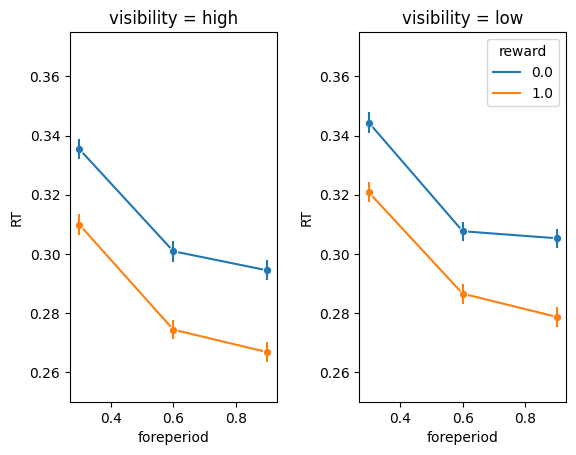

In [214]:
dataFrame = pd.DataFrame(data)
dataFrame.columns = ["participant", "block", "trial", "reward", "visibility", "foreperiod", "location", "RT"]

dataFrame.drop('participant', inplace=True, axis=1)
dataFrame.drop('block', inplace=True, axis=1)
dataFrame.drop('trial', inplace=True, axis=1)
dataFrame.drop('location', inplace=True, axis=1)    # not being considered at the moment

df1 = dataFrame[dataFrame["visibility"] == 1]
df2 = dataFrame[dataFrame["visibility"] == 0]

fig, ax = plt.subplots(1,2)
ax1 = sns.lineplot(data=df1, x="foreperiod", y="RT", hue = "reward", ax=ax[0], marker="o", err_style="bars", errorbar=('ci', 95), legend=False)
ax2 = sns.lineplot(data=df2, x="foreperiod", y="RT", hue = "reward", ax=ax[1], marker="o", err_style="bars", errorbar=('ci', 95))

ax1.set_ylim(0.25, 0.375)
ax2.set_ylim(0.25, 0.375)

ax1.set(title="visibility = high")
ax2.set(title="visibility = low")
fig.subplots_adjust(wspace=0.4)

### LMM